# Tabular binary classification with neural networks: keras
Here we create a fully-connected artificial neural network based on the kaggle ["Intro to Deep Learning"](https://www.kaggle.com/learn/intro-to-deep-learning) course written by [Ryan Holbrook](https://www.kaggle.com/ryanholbrook). We shall be using [Keras](https://keras.io/), the python deep learning API.
For our data we shall be using the [Santander Customer Satisfaction](https://www.kaggle.com/c/santander-customer-satisfaction) dataset.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy  as np
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# Read in the csv data using pandas 
train  = pd.read_csv('../input/santander-customer-satisfaction/train.csv',index_col=0)
test   = pd.read_csv('../input/santander-customer-satisfaction/test.csv', index_col=0)
sample = pd.read_csv('../input/santander-customer-satisfaction/sample_submission.csv')

The first thing we shall do is take a look at what types of data we have to train with. Categorical features can be handled via [embedding](https://www.fast.ai/2018/04/29/categorical-embeddings/).

In [3]:
train.dtypes.value_counts()

int64      259
float64    111
dtype: int64

we have no strings, so we shall not be using the aforementioned embedding. However, we do have a large number of integer columns. Let us take a look at how many different values each of these integer columns have (this is a long list, so it has been hidden. Click on "Show hidden" to take a look)

In [4]:
train.select_dtypes(include=['int64']).nunique()

var3                             208
var15                            100
ind_var1_0                         2
ind_var1                           2
ind_var2_0                         1
ind_var2                           1
ind_var5_0                         2
ind_var5                           2
ind_var6_0                         2
ind_var6                           2
ind_var8_0                         2
ind_var8                           2
ind_var12_0                        2
ind_var12                          2
ind_var13_0                        2
ind_var13_corto_0                  2
ind_var13_corto                    2
ind_var13_largo_0                  2
ind_var13_largo                    2
ind_var13_medio_0                  2
ind_var13_medio                    2
ind_var13                          2
ind_var14_0                        2
ind_var14                          2
ind_var17_0                        2
ind_var17                          2
ind_var18_0                        2
i

we can see that a good many of the integer features have one single value. Such columns have zero variance and thus have no predictive value, so we shall drop these columns from the train, as well as the test data to maintain consistency

In [5]:
features_to_drop = train.nunique()
features_to_drop = features_to_drop.loc[features_to_drop.values==1].index
# now drop these columns from both the training and the test datasets
train = train.drop(features_to_drop,axis=1)
test  = test.drop(features_to_drop,axis=1)

Now let us check for any missing values, as these do not sit well with neural networks

In [6]:
train.isnull().values.any()

False

wonderful, there are no missing values at all. Now let us divide the training data into the features and the target

In [7]:
X = train.iloc[:,:-1]
y = train['TARGET']

Check to see whether the data is [highly imbalanced or not](https://www.kaggle.com/carlmcbrideellis/classification-how-imbalanced-is-imbalanced)

In [8]:
y.value_counts().to_frame().T

,0,1
TARGET,73012,3008


indeed there is a large class imbalance, in view of this we shall resample the minority class using [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (Synthetic Minority Over-sampling Technique) from the [imbalanced-learn](https://imbalanced-learn.org/stable/) library

In [9]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

let us take a look

In [10]:
y_resampled.value_counts().to_frame().T

,0,1
TARGET,73012,73012


much better. 

As this is a large dataset we shall only use 50% of the data for training, and 20% for validation

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, 
                                                  train_size=0.5,
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle=True)

also, neural networks like to have data all in the same range, for example [0,1] to improve stability. We shall do this using the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
Note: One should really remove any outliers before doing this as a single outlier can have a large influence on the results

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
test    = scaler.transform(test)

We are now ready to create our neural network, note that we insert a [dropout layer](https://keras.io/api/layers/regularization_layers/dropout/) as a form of regularization which will  help reduce overfitting by randomly setting (here 30%) of the input unit values to zero.

In [13]:
model = keras.Sequential(
    [
        keras.layers.Dense(units=9, activation="relu", input_shape=(X_train.shape[-1],) ),
        # randomly delete 30% of the input units below
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=9, activation="relu"),
        # the output layer, with a single neuron
        keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# save the initial weights for later
initial_weights = model.get_weights()

let us take a look at our model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 3024      
_________________________________________________________________
dropout (Dropout)            (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 10        
Total params: 3,124
Trainable params: 3,124
Non-trainable params: 0
_________________________________________________________________


or create a more aesthetically pleasing representation via

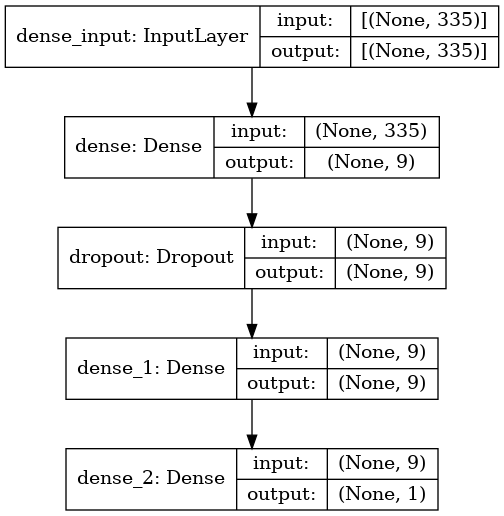

In [15]:
keras.utils.plot_model(model, show_shapes=True)

We shall use the [Adam](https://keras.io/api/optimizers/adam/) (Adaptive Moment Estimation) optimizer, a form of [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD). For more on the subject see the review ["*An overview of gradient descent optimization algorithms*"](https://arxiv.org/pdf/1609.04747.pdf), written by Sebastian Ruder.
As our problem is binary classification our [loss function](https://en.wikipedia.org/wiki/Loss_function) will be the [binary cross entropy](https://keras.io/api/losses/probabilistic_losses/). Finally, as per the [competition evaluation criteria](https://www.kaggle.com/c/santander-customer-satisfaction/overview/evaluation), we shall calculate the area under the curve (AUC) of the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

In [16]:
learning_rate = 0.001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="binary_crossentropy", 
              metrics=keras.metrics.AUC()
             )

we shall now train the model, providing 1000 rows of training data at a  time (`batch_size`), the whole process repeated 500 times (these are the `epochs`).
If the `batch_size` is  large, it will take more `epochs` for the neural net to converge. For an interesting article on the subject see ["*Effect of Batch Size on Neural Net Training*"](https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57).

In [17]:
history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(X_val, y_val),
          verbose=0)

Take a look at how the training went, checking for either [overfitting or underfitting](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting), by plotting the so-called *learning curves*

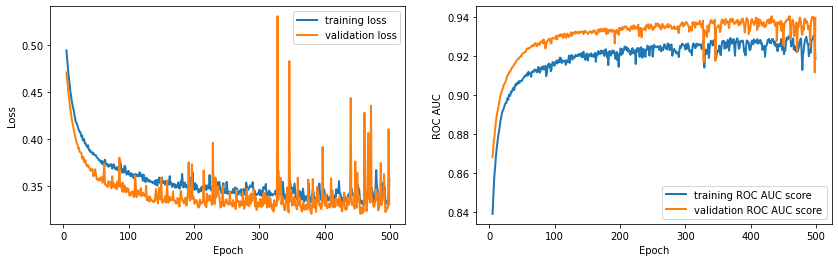

In [18]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

we can see that towards the end the validation ROC AUC score has leveled off and is not improving. We can also see that despite the validation ROC AUC score stagnating, the training ROC AUC score is still steadily rising; this is an indication that we are overfitting. Ideally we would like to watch out for this and call a halt to the training so as not to waste time and CPU/GPU. To do this we can set up a "callback":

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.0002, # minimium amount of change to count as an improvement
    patience  = 20,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

Now let us delete our old training and start anew. We do this by restoring the initial weights of our neural network:

In [20]:
model.set_weights(initial_weights)

In [21]:
history = model.fit(X_train, y_train, 
          epochs=500, 
          batch_size=1000, 
          validation_data=(X_val, y_val),
          verbose=0,
          # add in our early stopping callback
          callbacks=[early_stopping]
        )

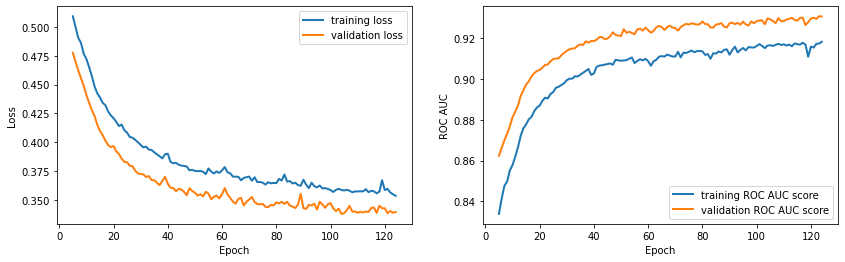

In [22]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

we have now finished training our neural network. Now let us use our model on the `test` data to predict the values, when it comes to neural networks the prediction stage is more commonly referred to  as *inference*:

In [23]:
sample['TARGET'] = model.predict(test)

Now write out a `submission.csv` file for submission to the competition for scoring. The scores for this model are given at the top of this notebook. As a reference point the winning score for this competition had a Private Leaderboard score of `0.82907`.

In [24]:
sample.to_csv('submission.csv',index=False)

# Related reading
It is well known that, when it comes to tabular data, neural networks have a difficult time competing with the likes of [XGBoost](https://www.kaggle.com/carlmcbrideellis/very-simple-xgboost-regression). However, progress is constantly being made in that respect, and the following papers make for some very interesting reading
* ["*Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data*"](https://arxiv.org/pdf/1909.06312.pdf) (2019)
* ["*TabNet: Attentive Interpretable Tabular Learning*"](https://arxiv.org/pdf/1908.07442.pdf) (2020)
* ["*Tabular Data: Deep Learning is Not All You Need*"](https://arxiv.org/pdf/2106.03253.pdf) (2021)
* ["*Regularization is all you Need: Simple Neural Nets can Excel on Tabular Data*"](https://arxiv.org/pdf/2106.11189.pdf) (2021)
* ["*Deep Neural Networks and Tabular Data: A Survey*"](https://arxiv.org/pdf/2110.01889.pdf) (2021)